## A sketch of the code benchmarking problem

Here we rough out a few necessary components for spectrum synthesis.

Lots of this will be done in pure python.  A few operations are done
with numpy if they are done only once.  It is the operations that are
done repeatedly that are the best candidates for code improvments.

Even without going all the way to C++, it would be good to replace
some pure python operations with numpy array functions and see how
much that improves things.

In [71]:
# Get packages
import matplotlib.pyplot as plt
import numpy as np
import time

In [72]:
# Specify needed items.

# Start, end wavelength for the spectrum and number of points
startw = 900.       # Angstroms
finalw = 2900.
nspect = 2048

# Number of lines in the spectrum model
nlines = 1000

# Width of each line in gaussian sigma, in Angstroms
lsigma = 4.0

# Width of halfnormal distribution.  We use a halfnormal distribution
# of line depths so most are near zero and only a few are much larger.
halfsig = 0.1

In [73]:
# Generate a wavelength list for the spectrum.
wavels = np.linspace(startw, finalw, nspect, endpoint=True)

### We need a list of wavelengths and line depths in order to synthesize a spectrum.

In [74]:
# Generate list of line depths and fix up so none are > 1.0
# We want the absolute value of a normal distribution

depths = np.absolute(np.random.normal(0.0, halfsig, nlines))
depths[depths > 1.0] = 1.0
print(depths)

# Generate a list of line wavelengths, which we take as
# uniformly distributed over the spectrum
lwaves = np.random.uniform(startw, finalw, nlines)
print(lwaves)


[3.49846179e-02 2.94607768e-02 7.54277958e-02 8.97518304e-02
 6.33599638e-02 3.92077708e-02 1.25828458e-02 1.34597246e-01
 1.71971097e-01 9.82981119e-04 7.72001749e-03 3.05064353e-02
 1.49196182e-01 1.11505657e-01 8.33976391e-02 1.99564552e-02
 2.84768842e-02 1.46597269e-01 2.16899050e-01 9.79940711e-02
 1.55451156e-01 1.14474851e-03 4.04171343e-02 4.71264791e-03
 3.89335941e-02 1.49184913e-01 1.18834161e-01 6.02395439e-02
 3.78953714e-02 1.16668729e-01 4.67205596e-03 5.20526743e-02
 5.83480203e-02 1.99935059e-02 7.04855167e-02 1.37019326e-01
 2.01486435e-02 4.47379125e-02 1.55092178e-01 6.61155272e-03
 3.48284048e-02 1.25912504e-01 2.34192948e-01 7.04277589e-02
 4.42428080e-04 1.03367248e-01 1.10337042e-01 4.73607647e-02
 1.34688725e-03 1.75380286e-01 9.48755247e-02 3.61761493e-02
 1.27412156e-01 1.54066635e-02 7.23282450e-02 1.08523419e-01
 7.30594406e-02 3.91730510e-02 8.62888623e-02 8.18465118e-02
 9.22194682e-02 2.23280563e-02 1.91205644e-01 2.02109920e-02
 2.17632016e-01 2.341173

### We start with a blank spectrum, then add on a series of lines.

In [75]:
# Function to return an I/Io spectrum, meaning a spectrum normalized so
# the continuum is 1 everywhere.
def blankspec(npts):
    """
    docstring here
    """
    B = [1.0 for n in range(npts)]
    return B

In [76]:
# Gauss function
from numpy import exp
def gauss(w, cent, depth, sigma):
    """
    docstring here
    """
    gval = -depth * exp(-(w - cent)**2 / 2.0 / sigma**2)
    return gval

In [77]:
# Test with a single line
linecenter = 2023.9
linedepth  = 0.4

blank = blankspec(nspect)
spect = []
for k in range(len(wavels)):
    w = wavels[k]
    d = gauss(w, linecenter, linedepth, lsigma)
    s = blank[k] + d
    spect.append(s)

Text(0, 0.5, 'Spectrum')

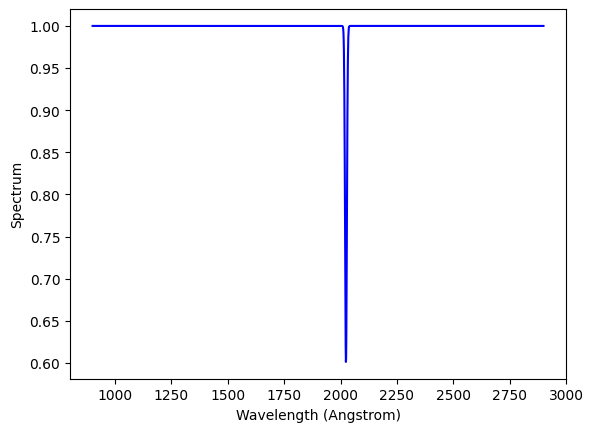

In [78]:
fig, ax = plt.subplots()
ax.plot(wavels, spect, 'blue')
ax.set_xlabel('Wavelength (Angstrom)')
ax.set_ylabel('Spectrum')

### How to make a full spectrum.

For each line in the line list:
- Generate a spectrum with a single line. If there are N lines in the list, you get N spectra.
- Multiply all these together.

In [79]:
# Generate a spectrum with a single line, if there are N lines in the list you get N spectra
def genspec(wavels, lwave, depth, lsigma):
    blank = blankspec(len(wavels))
    spect = []
    for k in range(len(wavels)):
        w = wavels[k]
        d = gauss(w, lwave, depth, lsigma)
        s = blank[k] + d
        spect.append(s)
    return spect

spectrums = []
for N in range(nlines):
    lwave = lwaves[N]
    depth = depths[N]
    spectrums.append(genspec(wavels, lwave, depth, lsigma))
    #plt.plot(wavels, spect, 'blue')
    #plt.show()

## Writing it in to a file for C

In [80]:

# open file in write mode
with open(r'spectrums.txt', 'w') as fp:
    for item in spectrums:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


### Multiply the spectra

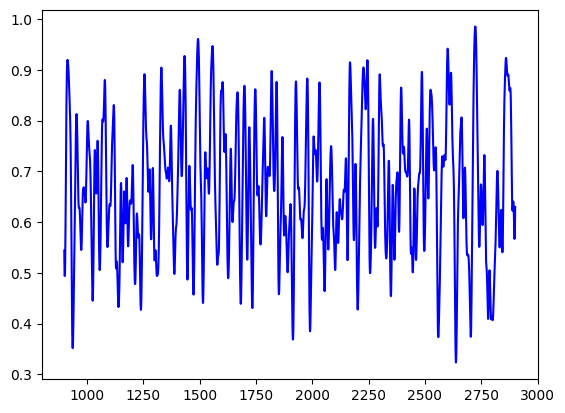

In [81]:
start_time_py = time.perf_counter()

# Multiply all the spectra together
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = [final[n] * spectrums[k][n] for n in range(len(final))]
end_time_py = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()



### Doing it with numpy

We'll use numpy as a middleman to mulitplying spectra entirely in C or C++ because [Numpy uses pre-compiled C code](https://numpy.org/doc/stable/user/whatisnumpy.html)

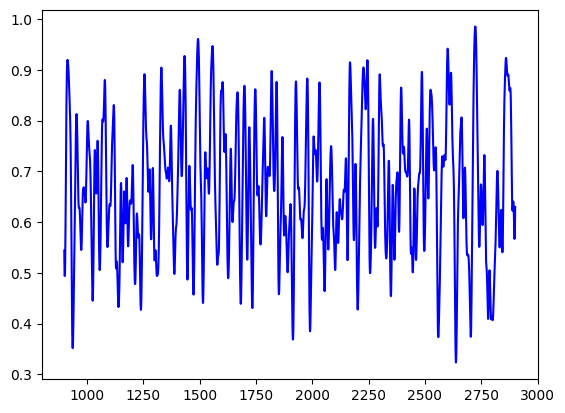

In [82]:
start_time_np = time.perf_counter()
# Multiply all the spectra together with numpy
final = spectrums[0]
for k in range(1, len(spectrums)):
    final = np.multiply(final, spectrums[k])
end_time_np = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()

In [83]:
print("Python time: ", end_time_py - start_time_py)
print("Numpy  time: ", end_time_np - start_time_np)

Python time:  0.17367195800034096
Numpy  time:  0.05986174999998184


### Timing of the code

The time to multiply two spectra in c++ was much faster than even numpy.
For a random set of data the time to run this spectra multiplication in pure python was 

Time taken by function: 0.021867 seconds

In [84]:
from functools import reduce
 
result1 = reduce((lambda x, y: x * y), list1)

final = spectrums[0]
for k in range(1, len(spectrums)):
    final = reduce(final, spectrums[k])
end_time_np = time.perf_counter()

plt.plot(wavels, final, 'blue')
plt.show()



NameError: name 'list1' is not defined